In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.family'] = "AppleGothic"

from sklearn.ensemble import RandomForestRegressor

from statsmodels.stats.outliers_influence import variance_inflation_factor
from pycaret.regression import *
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pandas_profiling
import statsmodels.api as sm
from sklearn.decomposition import PCA

In [2]:
grid_500 = pd.read_csv('/Users/Desktop/DataCampus/data/final_data/500grid_data.csv')

In [7]:
grid_500['성폭력취약인구'] = grid_500['고등여성인구']+grid_500['20대여성인구']
grid_500['GRADE_폭력'] = grid_500['GRADE_폭력'].apply(lambda x: x-1 if x>0 else x)
grid_500['GRADE_절도'] = grid_500['GRADE_절도'].apply(lambda x: x-1 if x>0 else x)
grid_500['GRADE_성폭력'] = grid_500['GRADE_성폭력'].apply(lambda x: x-1 if x>0 else x)

In [24]:
numerical_feats = grid_500.dtypes[grid_500.dtypes != "object"].index.tolist()
numerical_feats.remove('INDEX')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = grid_500.dtypes[grid_500.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  41
Number of Categorical features:  2


### Stepwise

In [30]:
# 변수선택을 통해 형성한 모델의 AIC를 구하는 함수
# AIC가 낮을 수록 모델이 좋다고 평가된다.
# 다중 선형회귀분석
x_data = grid_500[['총인구', '남성인구', '여성인구', '고등여성인구', '20대여성인구', '유소년인구',
       '고령인구', '30년이상35년미만건축물', '35년이상건축물', '개별주택가격', '공시지가', '가로등',
       '공영주차장', '공중화장실', '교육시설', '교통사고_19', '교통사고_20', '노숙인시설', '대규모점포',
       '대부업현황', '룸살롱', '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집',
       '오락시설', '원룸_오피스텔', '유흥시설', '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도',
       '성폭력취약인구']] #변수 여러개
target = grid_500[["GRADE_폭력"]]

x_data1 = sm.add_constant(x_data, has_constant = "add")


def processSubset(X,y):
    model = sm.OLS(y,X) # Modeling
    regr = model.fit() # model fitting
    AIC = regr.aic # model's AIC
    return {"model" : regr, "AIC" : AIC}
    
processSubset(X = x_data1, y = target)

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f97e5d87d30>,
 'AIC': 2645.0712390076487}

## 전진 선택법

In [31]:
x_data = grid_500[['총인구', '남성인구', '여성인구', '고등여성인구', '20대여성인구', '유소년인구',
       '고령인구', '30년이상35년미만건축물', '35년이상건축물', '개별주택가격', '공시지가', '가로등',
       '공영주차장', '공중화장실', '교육시설', '교통사고_19', '교통사고_20', '노숙인시설', '대규모점포',
       '대부업현황', '룸살롱', '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집',
       '오락시설', '원룸_오피스텔', '유흥시설', '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도',
       '성폭력취약인구']] #변수 여러개

target = grid_500[["GRADE_폭력"]]

selected_variables = [] ## 선택된 변수들

sl_enter = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(x_data) > 0:
    remainder = list(set(x_data) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = x_data[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(target,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(target,sm.add_constant(x_data[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [32]:
selected_variables

['cctv',
 '유흥시설',
 '남성인구',
 '보안등',
 '35년이상건축물',
 '개별주택가격',
 '유소년인구',
 '성폭력취약인구',
 '룸살롱',
 '가로등',
 '횡단보도',
 '술집',
 '교통사고_19',
 '교통사고_20',
 '대규모점포',
 '신호등',
 '노숙인시설']

In [33]:
# 다중 선형회귀분석
x_data = grid_500[selected_variables]
target = grid_500[["GRADE_폭력"]]

# for b0, 상수항 추가
x_data1 = sm.add_constant(x_data, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(target, x_data1)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               GRADE_폭력   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     170.3
Date:                Wed, 18 Aug 2021   Prob (F-statistic):          4.70e-267
Time:                        14:31:58   Log-Likelihood:                -1296.9
No. Observations:                 918   AIC:                             2630.
Df Residuals:                     900   BIC:                             2717.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0762      0.045      1.695      0.090      -0.012       0.164
cctv           0.1117      0.024      4.628      0.000       0.064       0.159
유흥시설           0.0004      0.003      0.142      0.887      -0.006       0.006
남성인구           0.0038      0.000     11.487      0.000       0.003       0.004
보안등           -0.0182      0.002    -10.888      0.000      -0.021      -0.015
35년이상건축물       0.0025      0.001      3.829      0.000       0.001       0.004
개별주택가격      3.187e-09   4.22e-10      7.553      0.000    2.36e-09    4.02e-09
유소년인구         -0.0043      0.001     -7.917      0.000      -0.005      -0.003
성폭력취약인구       -0.0108      0.001     -7.380      0.000      -0.014      -0.008
룸살롱            0.0585      0.017      3.537      0.000       0.026       0.091
가로등            0.0087      0.002      4.280      0.000       0.005       0.013
횡단보도           0.0198      0.004      4.587      0.000       0.011       0.028
술집             0.0605      0.017      3.505      0.000       0.027       0.094
교통사고_19        0.0411      0.011      3.757      0.000       0.020       0.063
교통사고_20       -0.0109      0.004     -2.637      0.009      -0.019      -0.003
대규모점포         -0.3423      0.144     -2.384      0.017      -0.624      -0.061
신호등           -0.0163      0.008     -2.071      0.039      -0.032      -0.001
노숙인시설          1.2136      0.589      2.061      0.040       0.058       2.369
==============================================================================
Omnibus:                      327.129   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1549.635
Skew:                           1.587   Prob(JB):                         0.00
Kurtosis:                       8.518   Cond. No.                     2.44e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.44e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

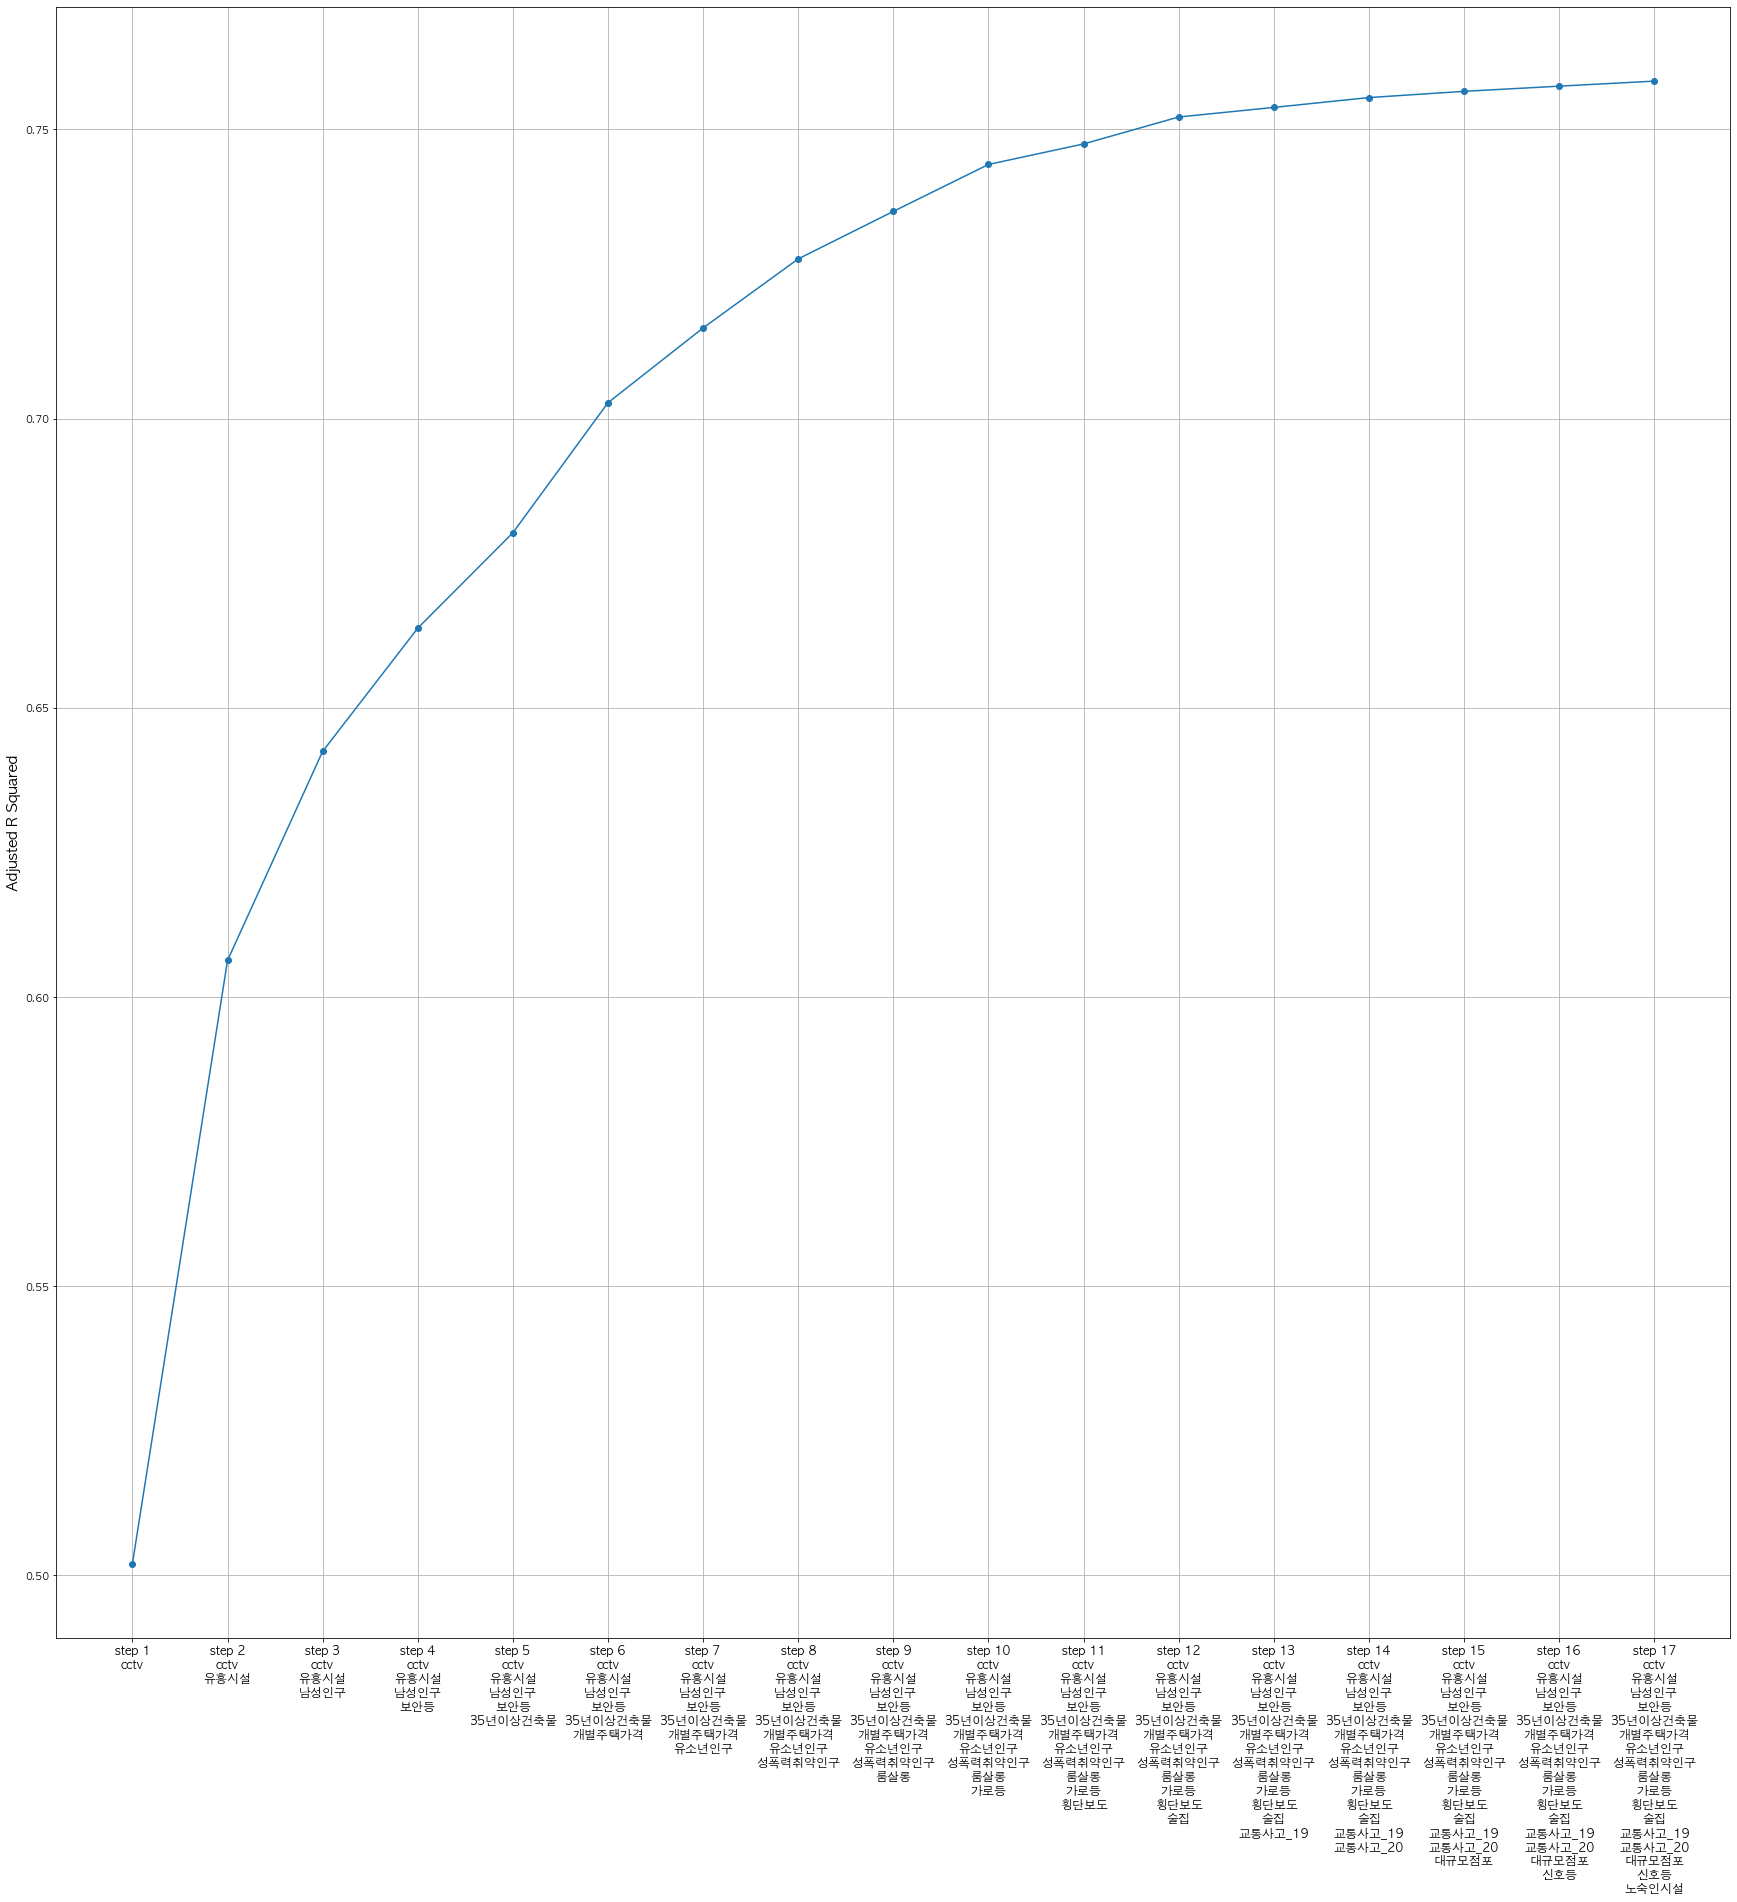

In [34]:
fig = plt.figure(figsize=(30,30))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

## 후진소거법

In [35]:
## 후진 소거법
x_data = grid_500[['총인구', '남성인구', '여성인구', '고등여성인구', '20대여성인구', '유소년인구',
       '고령인구', '30년이상35년미만건축물', '35년이상건축물', '개별주택가격', '공시지가', '가로등',
       '공영주차장', '공중화장실', '교육시설', '교통사고_19', '교통사고_20', '노숙인시설', '대규모점포',
       '대부업현황', '룸살롱', '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집',
       '오락시설', '원룸_오피스텔', '유흥시설', '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도',
       '성폭력취약인구']] #변수 여러개

target = grid_500[["GRADE_폭력"]]

selected_variables = x_data.columns.tolist()

sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(selected_variables) > 0:
    X = sm.add_constant(grid_500[selected_variables])
    p_vals = sm.OLS(target,X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
    max_pval = p_vals.max() ## 최대 p-value
    if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
        remove_variable = p_vals.idxmax()
        selected_variables.remove(remove_variable)
 
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(target,sm.add_constant(x_data[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [36]:
selected_variables

['총인구',
 '남성인구',
 '유소년인구',
 '35년이상건축물',
 '개별주택가격',
 '가로등',
 '교통사고_19',
 '교통사고_20',
 '노숙인시설',
 '대규모점포',
 '룸살롱',
 '보안등',
 '술집',
 '원룸_오피스텔',
 'cctv',
 '신호등',
 '횡단보도',
 '성폭력취약인구']

In [37]:
# 다중 선형회귀분석
x_data = grid_500[selected_variables]
target = grid_500[["GRADE_폭력"]]

# for b0, 상수항 추가
x_data1 = sm.add_constant(x_data, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(target, x_data1)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               GRADE_폭력   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     162.6
Date:                Wed, 18 Aug 2021   Prob (F-statistic):          1.01e-267
Time:                        14:32:00   Log-Likelihood:                -1292.6
No. Observations:                 918   AIC:                             2623.
Df Residuals:                     899   BIC:                             2715.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0687      0.045      1.524      0.128      -0.020       0.157
총인구           -0.0021      0.001     -2.507      0.012      -0.004      -0.000
남성인구           0.0079      0.002      4.668      0.000       0.005       0.011
유소년인구         -0.0044      0.001     -8.250      0.000      -0.005      -0.003
35년이상건축물       0.0021      0.001      3.223      0.001       0.001       0.003
개별주택가격      3.188e-09   4.33e-10      7.364      0.000    2.34e-09    4.04e-09
가로등            0.0086      0.002      4.358      0.000       0.005       0.012
교통사고_19        0.0400      0.011      3.721      0.000       0.019       0.061
교통사고_20       -0.0104      0.004     -2.505      0.012      -0.018      -0.002
노숙인시설          1.2252      0.586      2.090      0.037       0.075       2.376
대규모점포         -0.3312      0.136     -2.439      0.015      -0.598      -0.065
룸살롱            0.0559      0.016      3.499      0.000       0.025       0.087
보안등           -0.0168      0.002     -9.902      0.000      -0.020      -0.014
술집             0.0630      0.009      6.719      0.000       0.045       0.081
원룸_오피스텔       -0.0046      0.002     -2.423      0.016      -0.008      -0.001
cctv           0.1230      0.026      4.808      0.000       0.073       0.173
신호등           -0.0156      0.008     -1.985      0.047      -0.031      -0.000
횡단보도           0.0198      0.004      4.677      0.000       0.011       0.028
성폭력취약인구       -0.0085      0.002     -5.140      0.000      -0.012      -0.005
==============================================================================
Omnibus:                      323.991   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1494.525
Skew:                           1.580   Prob(JB):                         0.00
Kurtosis:                       8.394   Cond. No.                     2.44e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.44e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

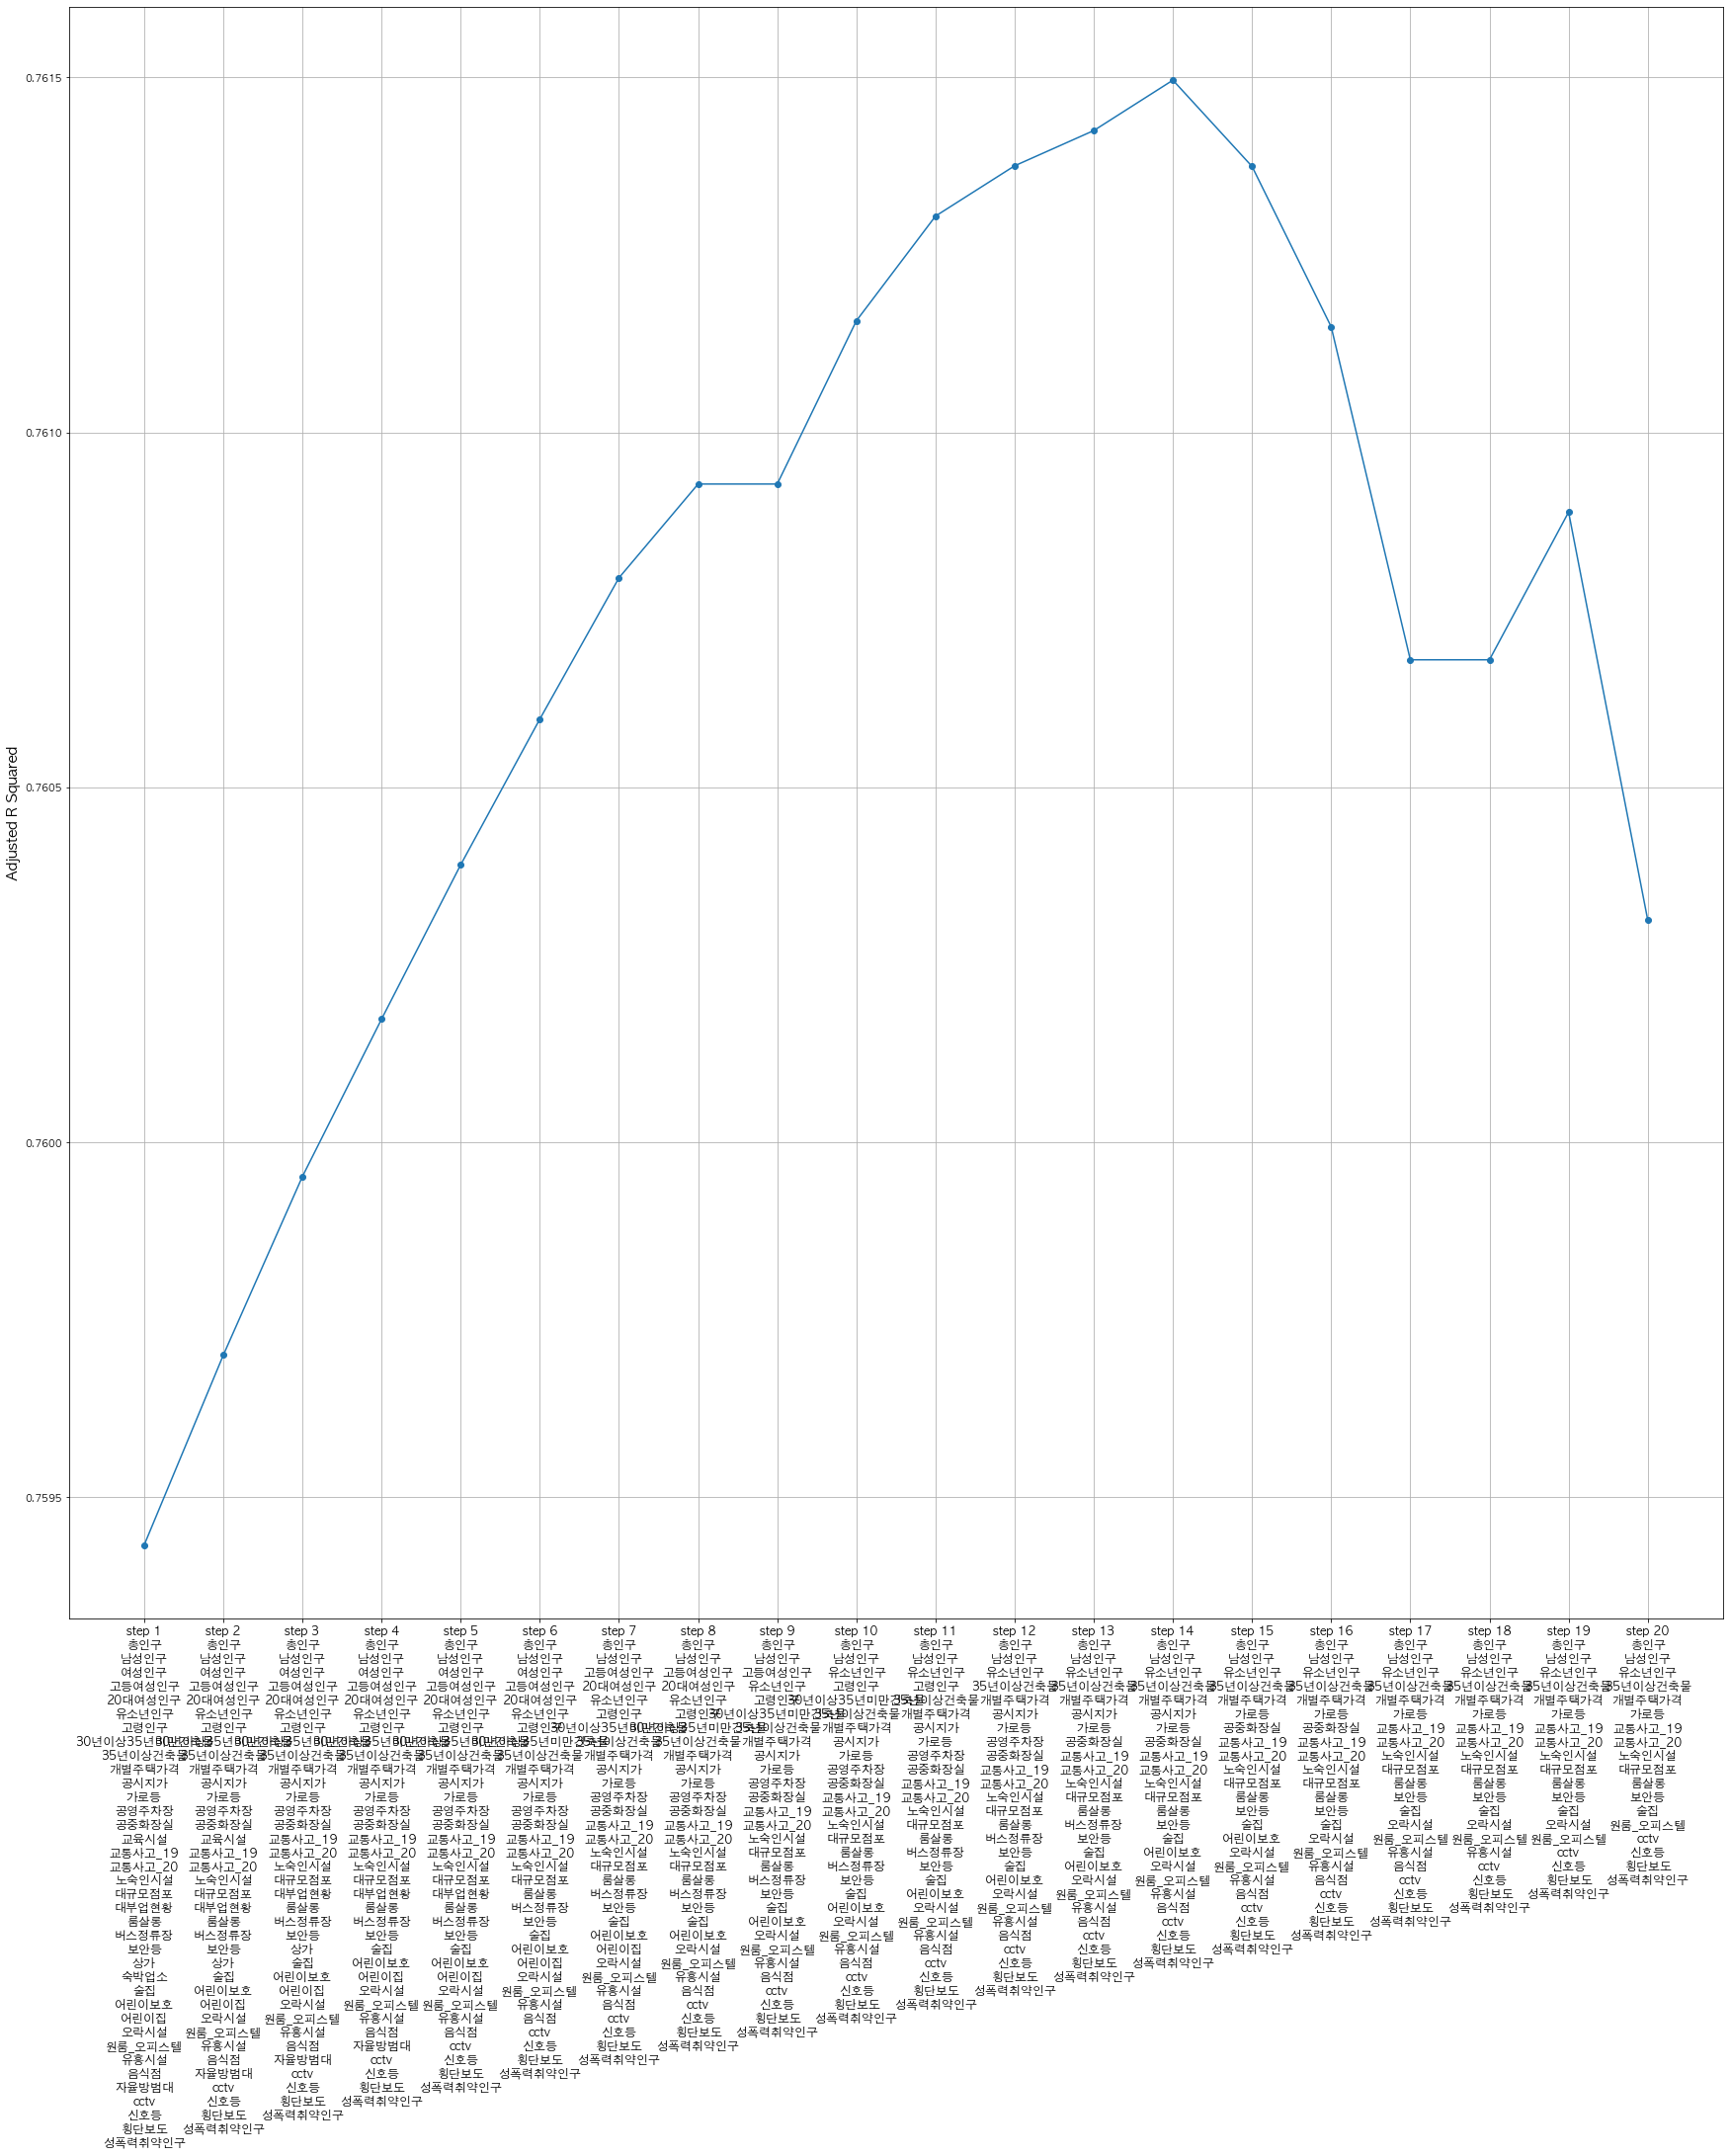

In [38]:
fig = plt.figure(figsize=(30,30))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

In [39]:
## 전진 단계별 선택법
x_data = grid_500[['총인구', '남성인구', '여성인구', '고등여성인구', '20대여성인구', '유소년인구',
       '고령인구', '30년이상35년미만건축물', '35년이상건축물', '개별주택가격', '공시지가', '가로등',
       '공영주차장', '공중화장실', '교육시설', '교통사고_19', '교통사고_20', '노숙인시설', '대규모점포',
       '대부업현황', '룸살롱', '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집',
       '오락시설', '원룸_오피스텔', '유흥시설', '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도',
       '성폭력취약인구']] #변수 여러개
variables = x_data.columns.tolist() ## 설명 변수 리스트
 
y = grid_500['GRADE_폭력'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = grid_500[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(target,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = grid_500[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(target,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(target,sm.add_constant(grid_500[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [40]:
selected_variables

['cctv',
 '남성인구',
 '보안등',
 '35년이상건축물',
 '개별주택가격',
 '유소년인구',
 '성폭력취약인구',
 '룸살롱',
 '가로등',
 '횡단보도',
 '술집',
 '교통사고_19',
 '교통사고_20',
 '대규모점포',
 '신호등',
 '노숙인시설']

In [41]:
# 다중 선형회귀분석
x_data = grid_500[selected_variables]
target = grid_500[["GRADE_폭력"]]

# for b0, 상수항 추가
x_data1 = sm.add_constant(x_data, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(target, x_data1)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               GRADE_폭력   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     181.1
Date:                Wed, 18 Aug 2021   Prob (F-statistic):          3.47e-268
Time:                        14:32:08   Log-Likelihood:                -1296.9
No. Observations:                 918   AIC:                             2628.
Df Residuals:                     901   BIC:                             2710.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0758      0.045      1.691      0.091      -0.012       0.164
cctv           0.1111      0.024      4.669      0.000       0.064       0.158
남성인구           0.0038      0.000     11.610      0.000       0.003       0.004
보안등           -0.0181      0.002    -11.013      0.000      -0.021      -0.015
35년이상건축물       0.0025      0.001      3.829      0.000       0.001       0.004
개별주택가격      3.187e-09   4.22e-10      7.556      0.000    2.36e-09    4.01e-09
유소년인구         -0.0043      0.001     -8.002      0.000      -0.005      -0.003
성폭력취약인구       -0.0108      0.001     -7.395      0.000      -0.014      -0.008
룸살롱            0.0579      0.016      3.615      0.000       0.026       0.089
가로등            0.0087      0.002      4.402      0.000       0.005       0.013
횡단보도           0.0199      0.004      4.697      0.000       0.012       0.028
술집             0.0625      0.009      6.686      0.000       0.044       0.081
교통사고_19        0.0414      0.011      3.849      0.000       0.020       0.063
교통사고_20       -0.0109      0.004     -2.639      0.008      -0.019      -0.003
대규모점포         -0.3354      0.135     -2.482      0.013      -0.601      -0.070
신호등           -0.0163      0.008     -2.071      0.039      -0.032      -0.001
노숙인시설          1.2174      0.588      2.071      0.039       0.064       2.371
==============================================================================
Omnibus:                      326.851   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1548.390
Skew:                           1.585   Prob(JB):                         0.00
Kurtosis:                       8.516   Cond. No.                     2.44e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.44e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

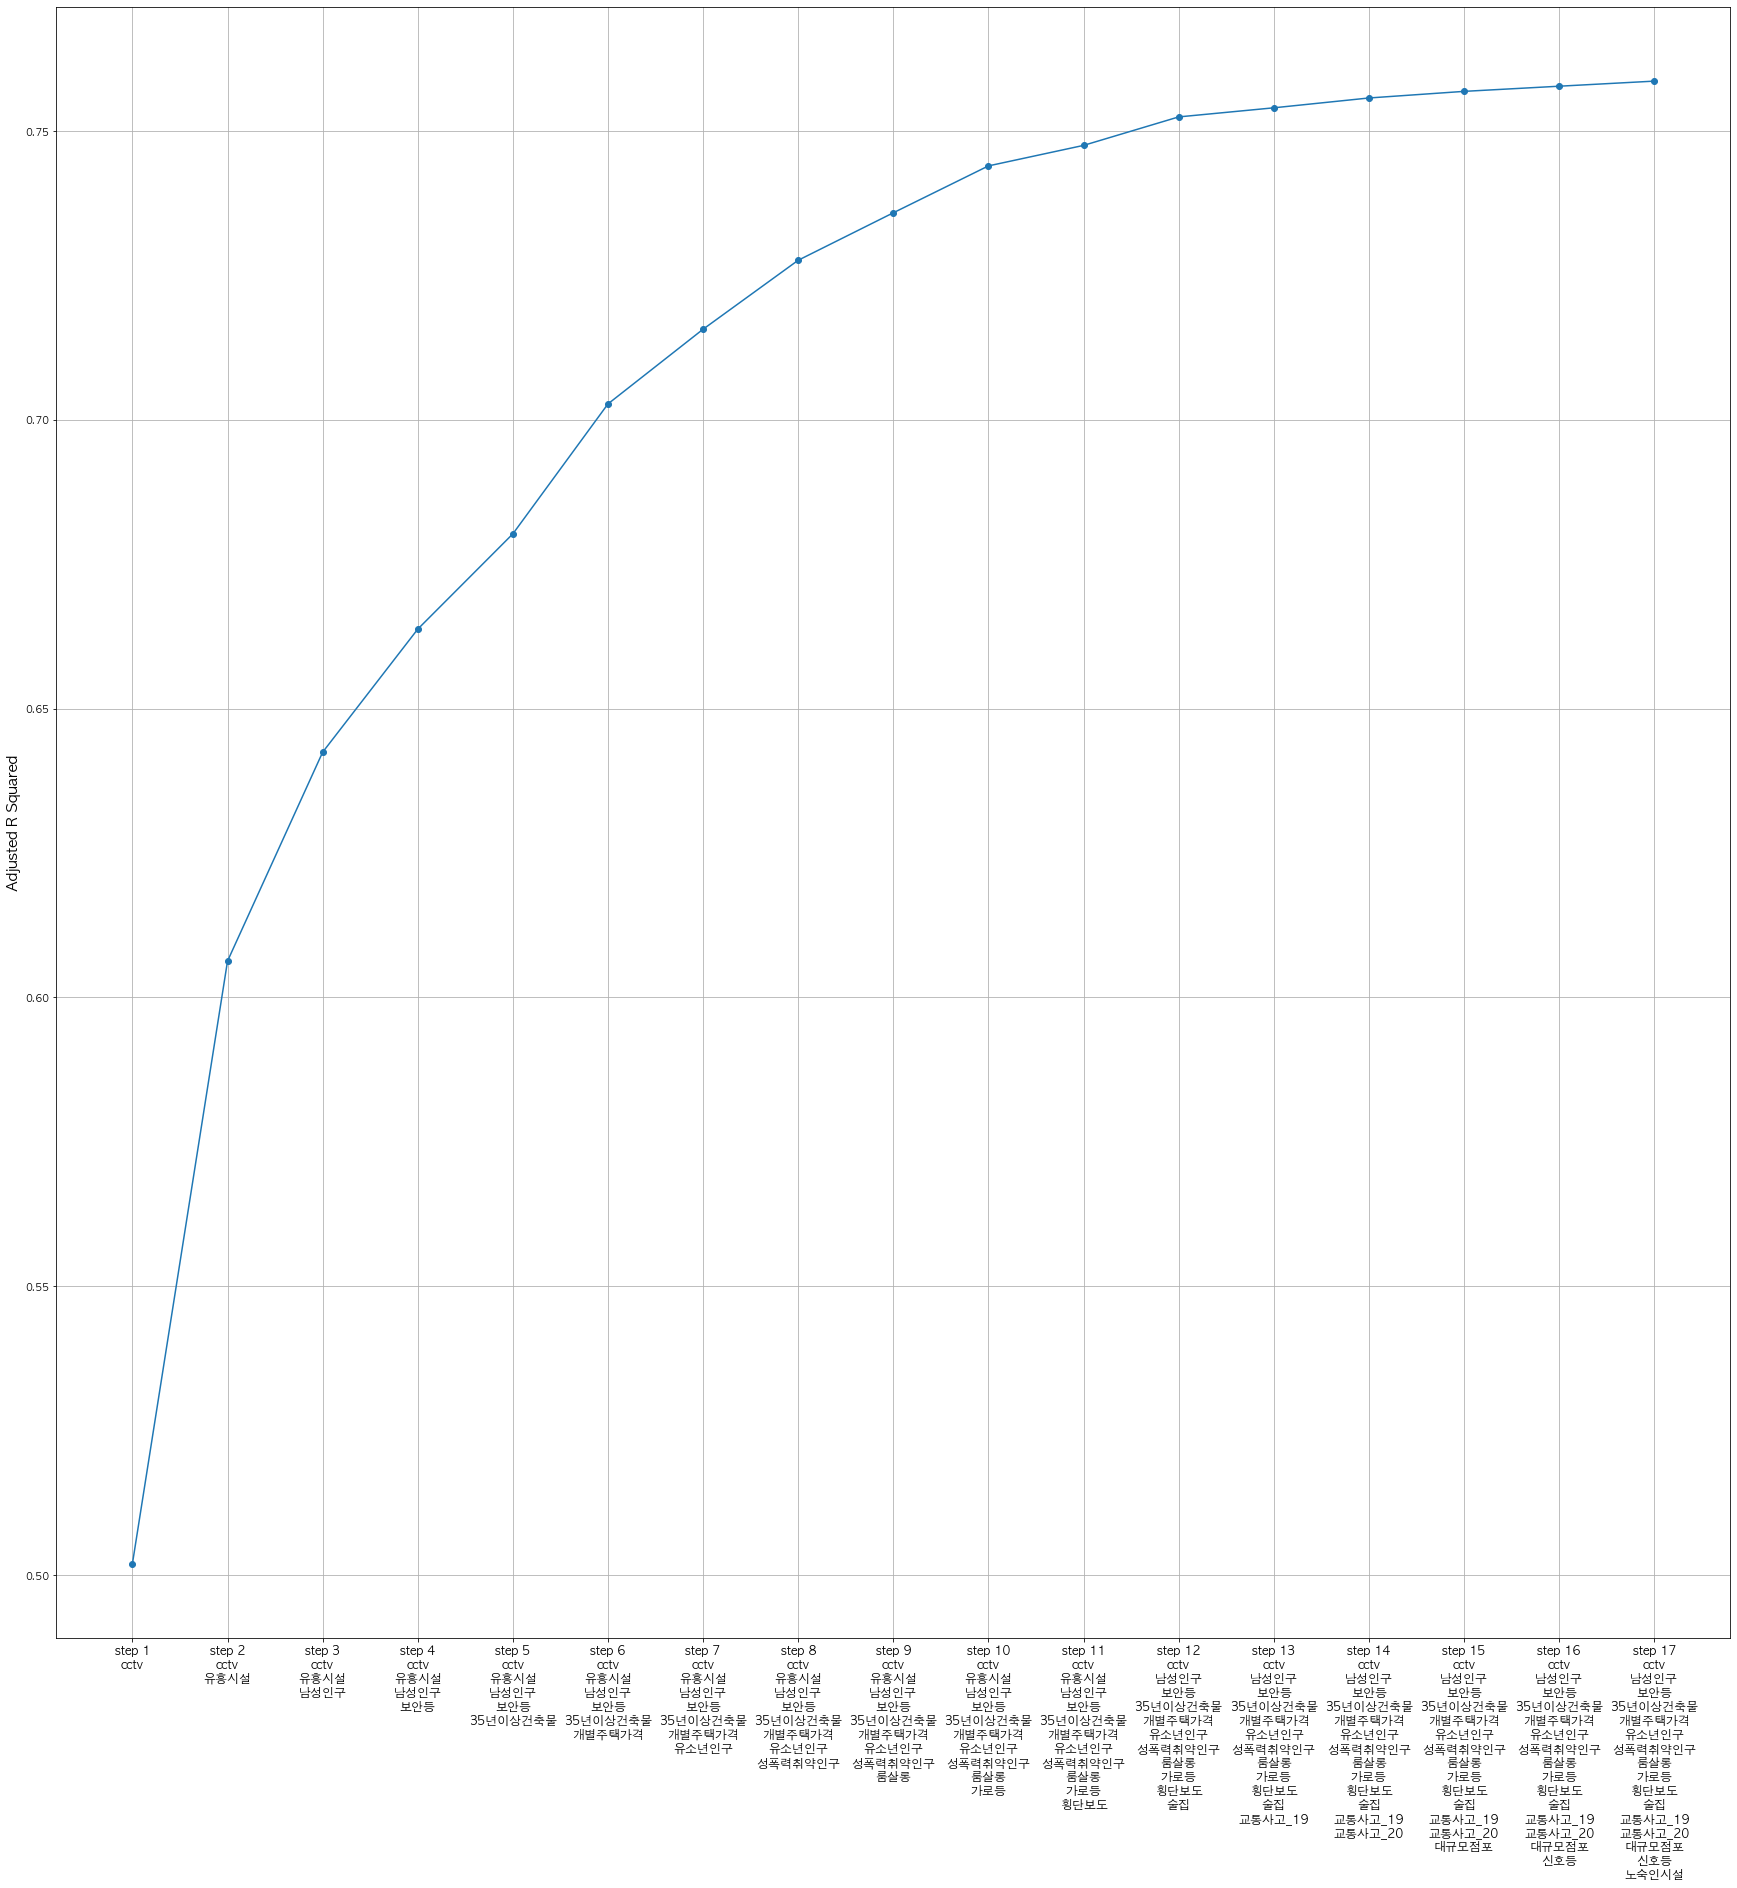

In [42]:
fig = plt.figure(figsize=(30,30))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

### standardscale

In [43]:
scaler = StandardScaler()
grid_500[numerical_feats] = scaler.fit_transform(grid_500[numerical_feats])

In [44]:
## 전진 단계별 선택법
x_data = grid_500[['총인구', '남성인구', '여성인구', '고등여성인구', '20대여성인구', '유소년인구',
       '고령인구', '30년이상35년미만건축물', '35년이상건축물', '개별주택가격', '공시지가', '가로등',
       '공영주차장', '공중화장실', '교육시설', '교통사고_19', '교통사고_20', '노숙인시설', '대규모점포',
       '대부업현황', '룸살롱', '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집',
       '오락시설', '원룸_오피스텔', '유흥시설', '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도',
       '성폭력취약인구']] #변수 여러개
variables = x_data.columns.tolist() ## 설명 변수 리스트
 
y = grid_500['GRADE_폭력'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = grid_500[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(target,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = grid_500[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(target,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(target,sm.add_constant(grid_500[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [45]:
selected_variables

['cctv',
 '남성인구',
 '보안등',
 '35년이상건축물',
 '개별주택가격',
 '유소년인구',
 '성폭력취약인구',
 '룸살롱',
 '가로등',
 '횡단보도',
 '술집',
 '교통사고_19',
 '교통사고_20',
 '대규모점포',
 '신호등',
 '노숙인시설']

In [46]:
# 다중 선형회귀분석
x_data = grid_500[selected_variables]
target = grid_500[["GRADE_폭력"]]

# for b0, 상수항 추가
x_data1 = sm.add_constant(x_data, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(target, x_data1)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               GRADE_폭력   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     181.1
Date:                Wed, 18 Aug 2021   Prob (F-statistic):          3.47e-268
Time:                        14:32:12   Log-Likelihood:                -642.09
No. Observations:                 918   AIC:                             1318.
Df Residuals:                     901   BIC:                             1400.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.028e-16      0.016  -6.34e-15      1.000      -0.032       0.032
cctv           0.1542      0.033      4.669      0.000       0.089       0.219
남성인구           1.4063      0.121     11.610      0.000       1.169       1.644
보안등           -0.2418      0.022    -11.013      0.000      -0.285      -0.199
35년이상건축물       0.0936      0.024      3.829      0.000       0.046       0.142
개별주택가격         0.1656      0.022      7.556      0.000       0.123       0.209
유소년인구         -0.4521      0.057     -8.002      0.000      -0.563      -0.341
성폭력취약인구       -0.7016      0.095     -7.395      0.000      -0.888      -0.515
룸살롱            0.0734      0.020      3.615      0.000       0.034       0.113
가로등            0.1295      0.029      4.402      0.000       0.072       0.187
횡단보도           0.1470      0.031      4.697      0.000       0.086       0.208
술집             0.1700      0.025      6.686      0.000       0.120       0.220
교통사고_19        0.1193      0.031      3.849      0.000       0.058       0.180
교통사고_20       -0.0490      0.019     -2.639      0.008      -0.085      -0.013
대규모점포         -0.0449      0.018     -2.482      0.013      -0.080      -0.009
신호등           -0.0656      0.032     -2.071      0.039      -0.128      -0.003
노숙인시설          0.0340      0.016      2.071      0.039       0.002       0.066
==============================================================================
Omnibus:                      326.851   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1548.390
Skew:                           1.585   Prob(JB):                         0.00
Kurtosis:                       8.516   Cond. No.                         25.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
## 후진 소거법
x_data = grid_500[['총인구', '남성인구', '여성인구', '고등여성인구', '20대여성인구', '유소년인구',
       '고령인구', '30년이상35년미만건축물', '35년이상건축물', '개별주택가격', '공시지가', '가로등',
       '공영주차장', '공중화장실', '교육시설', '교통사고_19', '교통사고_20', '노숙인시설', '대규모점포',
       '대부업현황', '룸살롱', '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집',
       '오락시설', '원룸_오피스텔', '유흥시설', '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도',
       '성폭력취약인구']] #변수 여러개

target = grid_500[["GRADE_폭력"]]

selected_variables = x_data.columns.tolist()

sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(selected_variables) > 0:
    X = sm.add_constant(grid_500[selected_variables])
    p_vals = sm.OLS(target,X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
    max_pval = p_vals.max() ## 최대 p-value
    if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
        remove_variable = p_vals.idxmax()
        selected_variables.remove(remove_variable)
 
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(target,sm.add_constant(x_data[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [48]:
selected_variables

['총인구',
 '남성인구',
 '유소년인구',
 '35년이상건축물',
 '개별주택가격',
 '가로등',
 '교통사고_19',
 '교통사고_20',
 '노숙인시설',
 '대규모점포',
 '룸살롱',
 '보안등',
 '술집',
 '원룸_오피스텔',
 'cctv',
 '신호등',
 '횡단보도',
 '성폭력취약인구']

In [86]:
# 다중 선형회귀분석
x_data = grid_500[selected_variables]
target = grid_500[["GRADE_폭력"]]

# for b0, 상수항 추가
x_data1 = sm.add_constant(x_data, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(target, x_data1)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               GRADE_폭력   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     162.6
Date:                Wed, 18 Aug 2021   Prob (F-statistic):          1.01e-267
Time:                        14:58:58   Log-Likelihood:                -637.84
No. Observations:                 918   AIC:                             1314.
Df Residuals:                     899   BIC:                             1405.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.028e-16      0.016  -6.36e-15      1.000      -0.032       0.032
총인구           -1.5718      0.627     -2.507      0.012      -2.802      -0.341
남성인구           2.8701      0.615      4.668      0.000       1.663       4.077
유소년인구         -0.4674      0.057     -8.250      0.000      -0.579      -0.356
35년이상건축물       0.0800      0.025      3.223      0.001       0.031       0.129
개별주택가격         0.1656      0.022      7.364      0.000       0.121       0.210
가로등            0.1280      0.029      4.358      0.000       0.070       0.186
교통사고_19        0.1151      0.031      3.721      0.000       0.054       0.176
교통사고_20       -0.0465      0.019     -2.505      0.012      -0.083      -0.010
노숙인시설          0.0343      0.016      2.090      0.037       0.002       0.066
대규모점포         -0.0443      0.018     -2.439      0.015      -0.080      -0.009
룸살롱            0.0709      0.020      3.499      0.000       0.031       0.111
보안등           -0.2247      0.023     -9.902      0.000      -0.269      -0.180
술집             0.1714      0.026      6.719      0.000       0.121       0.221
원룸_오피스텔       -0.0687      0.028     -2.423      0.016      -0.124      -0.013
cctv           0.1706      0.035      4.808      0.000       0.101       0.240
신호등           -0.0629      0.032     -1.985      0.047      -0.125      -0.001
횡단보도           0.1459      0.031      4.677      0.000       0.085       0.207
성폭력취약인구       -0.5542      0.108     -5.140      0.000      -0.766      -0.343
==============================================================================
Omnibus:                      323.991   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1494.525
Skew:                           1.580   Prob(JB):                         0.00
Kurtosis:                       8.394   Cond. No.                         155.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [74]:
final_data = grid_500[['총인구', '남성인구', '유소년인구','35년이상건축물', '개별주택가격', '가로등', '교통사고_19','교통사고_20', '노숙인시설', '대규모점포', '룸살롱', '보안등', '술집', '원룸_오피스텔', 'cctv','신호등', '횡단보도', '성폭력취약인구','GRADE_폭력']]
features = final_data[['총인구', '남성인구', '유소년인구', '35년이상건축물','개별주택가격', '가로등', '교통사고_19', '교통사고_20', '노숙인시설', '대규모점포', '룸살롱', '보안등', '술집', '원룸_오피스텔', 'cctv', '신호등', '횡단보도', '성폭력취약인구']]
label = final_data[['GRADE_폭력']]

In [82]:
print(len(final_data),final_data.head(1))

918         총인구      남성인구     유소년인구  35년이상건축물    개별주택가격       가로등   교통사고_19  \
0  0.681072  0.640152  0.421512 -0.278314  0.859172 -0.266892  1.023293   

    교통사고_20    노숙인시설     대규모점포       룸살롱       보안등        술집   원룸_오피스텔  \
0  0.167282 -0.05726 -0.151617 -0.115845  0.399775 -0.098374  0.080918   

       cctv       신호등      횡단보도   성폭력취약인구  GRADE_폭력  
0  0.542511 -0.502512 -0.431023  0.704448  1.385773  


In [76]:
#multi_model = sm.OLS(target, x_data1)
#fitted_multi_model = multi_model.fit()
#fitted_multi_model.summary()

In [84]:
from sklearn.model_selection import KFold

scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(final_data)):
    df_train = final_data.iloc[idx_train]
    df_test = final_data.iloc[idx_test]
    features = df_train[['총인구', '남성인구', '유소년인구', '35년이상건축물','개별주택가격', '가로등', '교통사고_19', '교통사고_20', '노숙인시설', '대규모점포', '룸살롱', '보안등', '술집', '원룸_오피스텔', 'cctv', '신호등', '횡단보도', '성폭력취약인구']]
    label = df_train[['GRADE_폭력']]
    
    x_data1 = sm.add_constant(features, has_constant = "add")
    multi_model = sm.OLS(label, x_data1)
    fitted_multi_model = multi_model.fit()
    
    pred = fitted_multi_model.predict(df_test)
    rss = ((df_test.GRADE_폭력 - pred) ** 2).sum()
    tss = ((df_test.GRADE_폭력 - df_test.GRADE_폭력.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(fitted_multi_model.rsquared, rsquared))

학습 R2 = 0.76863561, 검증 R2 = -1.85718544
학습 R2 = 0.76616681, 검증 R2 = -5.75971370
학습 R2 = 0.77643596, 검증 R2 = -3.85538327
학습 R2 = 0.76071070, 검증 R2 = -1.70243770
학습 R2 = 0.75967415, 검증 R2 = -3.21741518
학습 R2 = 0.75352833, 검증 R2 = -3.93769912
학습 R2 = 0.76072807, 검증 R2 = -5.56723153
학습 R2 = 0.76075167, 검증 R2 = -3.10936463
학습 R2 = 0.78421443, 검증 R2 = -3.63542006
학습 R2 = 0.77204001, 검증 R2 = -3.85373444


In [78]:
kfold= KFold(n_splits=5)
cv_accuracy = []

In [ ]:
n_iter = 0
for train_idx, test_idx in kfold.split(features) :
    X_